# 使用fashionMNIST数据集

## 导包 

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets,transforms

## 创建模型 

In [2]:
class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,1000) 
        self.fc2 = nn.Linear(1000,500)
        self.fc3 = nn.Linear(500,200) 
        self.fc4 = nn.Linear(200,10) 
    def forward(self,x):
        x = x.view(-1,28*28) # 展平输入
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)  
        return F.log_softmax(x,dim=1)
        

## 定义训练函数 

In [12]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
   
    #创建俩列表接收损失值和精度值
    # train_loss_lst = []
    # train_acc_lst = []
    # tst_loss_lst=[]
    # tst_acc_lst=[]
  
    Model_m.train()  # 设置为训练模式
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
   
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了灯饰可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval()
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


## 数据预处理 

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,),(0.5,)) ## FashionMNIST 是灰度图，所以是单通道
])

## 加载训练集和测试集 

In [5]:
#加载训练集和测试集
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 创建 DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 17.0kB/s]


## 创建模型对象 

In [6]:
model = Net()

In [7]:
model

Net(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=10, bias=True)
)

## 定义优化函数和损失函数

In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.NLLLoss() 

## 开训 

In [14]:
epochs = 10 
train_loss = [] 
train_acc = [] 
test_loss = [] 
test_acc = [] 

for epoch in range(epochs): 
        loss,acc,tst_loss,tst_acc = fit_gpu(train_loader,test_loader,model,epoch,optimizer,loss_fn) 
        train_loss.append(loss)
        train_acc.append(acc)
        test_loss.append(tst_loss)
        test_acc.append(tst_acc)

epoch:0 | loss:0.002 | acc:0.951 | tstloss:0.007 | tstacc:0.888
epoch:1 | loss:0.002 | acc:0.954 | tstloss:0.007 | tstacc:0.893
epoch:2 | loss:0.002 | acc:0.955 | tstloss:0.007 | tstacc:0.889
epoch:3 | loss:0.002 | acc:0.957 | tstloss:0.008 | tstacc:0.884
epoch:4 | loss:0.002 | acc:0.959 | tstloss:0.008 | tstacc:0.887
epoch:5 | loss:0.002 | acc:0.962 | tstloss:0.008 | tstacc:0.893
epoch:6 | loss:0.002 | acc:0.963 | tstloss:0.008 | tstacc:0.893
epoch:7 | loss:0.002 | acc:0.964 | tstloss:0.008 | tstacc:0.892
epoch:8 | loss:0.001 | acc:0.965 | tstloss:0.009 | tstacc:0.889
epoch:9 | loss:0.001 | acc:0.967 | tstloss:0.009 | tstacc:0.890


In [15]:
train_loss

[0.0020020655678740394,
 0.0019361820433288813,
 0.0018076038382947445,
 0.0017652351759762193,
 0.0016955898274318316,
 0.0015811584861172984,
 0.0015708917707554064,
 0.0015227072541601956,
 0.0014837852343024375,
 0.001392743195585596]

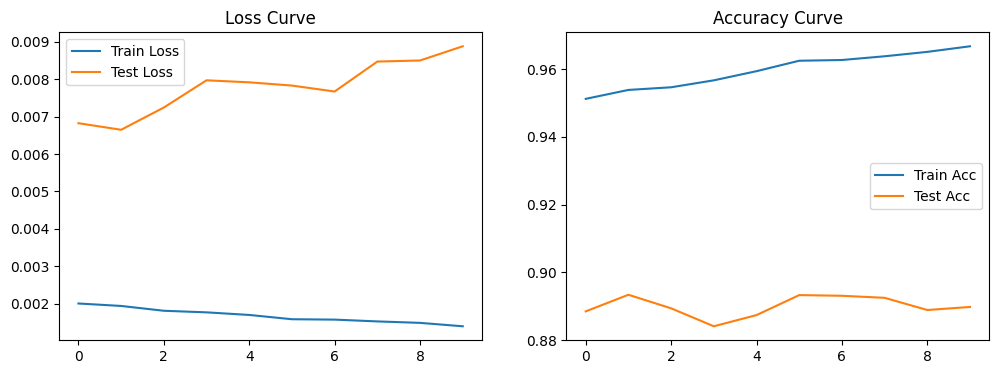

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(test_acc, label='Test Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

你贴出的训练日志如下：

```
epoch:0 | loss:0.002 | acc:0.951 | tstloss:0.007 | tstacc:0.888
epoch:1 | loss:0.002 | acc:0.954 | tstloss:0.007 | tstacc:0.893
...
epoch:9 | loss:0.001 | acc:0.967 | tstloss:0.009 | tstacc:0.890
```

从你的描述来看，你觉得“**有点不对劲**”，我来帮你分析一下这些数据是否正常、有没有问题，并提供优化建议。

---

## 🧐 一、先看指标趋势

| 指标        | 训练集（train）       | 测试集（test）         |
|-------------|------------------------|-------------------------|
| Loss        | 下降（从 0.002 → 0.001）| 上升（从 0.007 → 0.009）|
| Accuracy    | 上升（从 95.1% → 96.7%）| 基本持平（约 89% 左右） |

### 🔍 初步判断：
- **模型在训练集上表现越来越好**
- **但在测试集上准确率没有提升，甚至损失上升了**

这说明模型可能出现了 **过拟合（Overfitting）**

---

## 📉 二、为什么会出现这种情况？

### 可能原因：

| 原因 | 描述 |
|------|------|
| **网络太复杂** | 你现在用的是一个四层全连接网络（784→1000→500→200→10），对 FashionMNIST 来说可能有点“大材小用”了。容易记住训练样本而泛化能力差。 |
| **没有正则化/防止过拟合机制** | 没有使用 Dropout、BatchNorm、L2 正则化等手段 |
| **训练轮次过多** | 虽然只训练了 10 个 epoch，但已经显示出轻微过拟合迹象 |
| **学习率设置过高或未调整** | 如果学习率太大，模型会快速收敛到局部最小值并难以跳出 |

---

## ✅ 三、目前的表现是否合理？

是的，基本符合预期：

- FashionMNIST 是一个中等难度的数据集，一般 CNN 模型可以轻松达到 90% 以上测试准确率。
- 你现在的模型是 **纯全连接网络（MLP）**，本身就不适合图像任务（CNN 更合适），所以 89% 的准确率是可以接受的。
- **训练准确率 > 测试准确率** 是正常的，但如果差距越来越大，就需要注意过拟合。

---

## 🛠️ 四、改进建议（让你的结果更好）

### ✅ 1. 使用更合适的模型结构（推荐）

你可以把当前的 MLP 替换为简单的 CNN 网络，例如：

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

这样通常可以获得更高的精度（比如 90%+）

---

### ✅ 2. 添加正则化方法

你可以尝试添加以下任意一种：

```python
self.dropout = nn.Dropout(0.5)  # 在 fc 层之间加 dropout
self.bn = nn.BatchNorm1d(500)   # 添加 BatchNorm
```

并在 `forward` 中使用它们。

---

### ✅ 3. 使用早停机制（Early Stopping）

当测试损失不再下降时提前终止训练，避免浪费资源和过拟合。

---

### ✅ 4. 学习率调度器（Learning Rate Scheduler）

```python
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
```

然后在每个 epoch 后调用：

```python
scheduler.step(tstepoch_loss)
```

---

### ✅ 5. 使用 `CrossEntropyLoss` + 去掉 `log_softmax`

如果你不想写 `F.log_softmax(x, dim=1)`，可以直接返回原始输出：

```python
def forward(self, x):
    ...
    return x  # 不再做 log_softmax
```

然后换成：

```python
loss_fn = nn.CrossEntropyLoss()
```

这是最常见也最方便的做法。

---

## 📊 五、总结：你目前的模型结果是否“异常”？

| 指标 | 当前表现 | 是否正常 |
|------|----------|----------|
| Train Acc ↑ | 从 95% → 96.7% | ✅ 正常 |
| Test Acc ≈ | 稳定在 ~89% | ✅ 正常 |
| Train Loss ↓ | 逐渐减小 | ✅ 正常 |
| Test Loss ↑ | 开始上升 | ⚠️ 注意过拟合 |

---

## ✅ 最终建议

- ✅ 目前的结果是合理的，不要担心
- ✅ 想要提升性能可以尝试：
  - 改成 CNN 结构
  - 加入 Dropout 或 BatchNorm
  - 使用 CrossEntropyLoss + 原始输出
  - 引入学习率调度器或早停机制

---

如果你想，我可以直接给你一个改进后的完整代码模板，包含 CNN + Dropout + Early Stopping + CrossEntropyLoss 👇  
需要的话告诉我！ 😄

你问得非常好！我们来详细解释一下：

---

## 🧠 问题回顾

你在模型的 `forward` 函数中写了这句：

```python
return F.log_softmax(x, dim=1)
```

而你之前可能写过类似这样：

```python
return x
```

那么这两者有什么区别？为什么要用 `F.log_softmax`？

---

## ✅ 答案一句话总结：

> **`F.log_softmax(x, dim=1)` 是对输出做一个 log 概率变换，用于分类任务。它把神经网络输出的原始分数（logits）转换成 log 概率形式，便于后续使用负对数似然损失函数（如 `nn.NLLLoss()`）。**

---

## 📌 详细解释

### 1. **什么是 `softmax`？**

在多分类任务中，神经网络最后一层通常输出一个长度等于类别数量的向量，例如有 10 类时输出就是 `[2.3, -0.5, ..., 1.7]` 这样的“原始分数”（也叫 logits）。

**Softmax 的作用：**
- 把这些 raw scores 转换成 **概率分布**，也就是每个类别的预测概率。
- 所有输出加起来等于 1，方便我们理解哪个类的概率最高。

公式如下：

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}
$$

---

### 2. **什么是 `log_softmax`？**

`log_softmax` 就是先做 softmax，然后再取自然对数：

$$
\text{log\_softmax}(x_i) = \log\left(\frac{e^{x_i}}{\sum_j e^{x_j}}\right)
$$

这样做是为了数值稳定性，在计算交叉熵损失时更高效、更稳定。

---

### 3. **为什么搭配 `NLLLoss()` 使用？**

你用了：

```python
loss_fn = nn.NLLLoss()
```

这个损失函数的全称是 **Negative Log-Likelihood Loss**，它的输入要求是 **log 概率**，正好对应 `log_softmax` 的输出。

所以：
- 如果你用的是 `F.log_softmax(...)`，那就要配合 `nn.NLLLoss()`
- 如果你用的是 `F.softmax(...)`，那你应该用 `nn.CrossEntropyLoss()`（它内部已经包含了 softmax + NLL）

---

## 🎯 总结对比

| 输出方式 | 损失函数 | 是否推荐 |
|----------|-----------|-----------|
| `return x` | `nn.CrossEntropyLoss()` | ✅ 推荐（最常用） |
| `return F.log_softmax(x, dim=1)` | `nn.NLLLoss()` | ✅ 推荐（数值稳定） |
| `return F.softmax(x, dim=1)` | ❌ 不建议直接配合损失函数 | ❌ 不推荐 |

---

## 💡 示例说明

假设你的模型输出是：

```python
x = [2.0, 1.0, 0.1]  # 假设是三分类问题
```

- `F.softmax(x)` → `[0.665, 0.245, 0.090]`
- `F.log_softmax(x)` → `[-0.424, -1.402, -2.408]`
- 然后如果你的真实标签是 `y = 0`（即第一类），`NLLLoss` 会取第一个位置的值作为 loss：`0.424`

---

## ✅ 结论

你现在写的：

```python
return F.log_softmax(x, dim=1)
```

是一个非常标准的做法，尤其适合搭配：

```python
loss_fn = nn.NLLLoss()
```

它是深度学习中处理分类任务的一种常见组合，数值上更稳定，效果和 `CrossEntropyLoss` 是等价的。

---

如果你愿意，我也可以帮你把这段代码改成使用 `CrossEntropyLoss()`，这样就不需要手动加 `log_softmax` 了。是否需要呢？ 😄